In [117]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
pd.options.display.max_colwidth = 1000

In [118]:
df = pd.read_excel("../data_processed/individual/@AnasHaqqani313_men_pashtun.xlsx")
# df["created_at"] = pd.to_datetime(df["created_at"]).dt.date.astype(str)

In [119]:
# def check_keywords(text):
#     for word in keywords:
#         if word in text.lower():
#             return 1
#     return 0
#df["label"] = df["text"].apply(check_keywords)
#df["label"] = [1 if any(keyword in text.lower() for keyword in keywords) else 0 for text in df["text"]]
# keywords = ["education", "ban", "school"]

def label_tweets(text):
    keywords = ["women", "education", "ban", "school", "girls"]
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
    
    
df = df.copy()
df["label"] = df["text"].apply(label_tweets)

In [120]:
# Group the tweets by label and count the number of tweets in each group
label_counts = df.groupby("label").size()
# Print the label counts
print(label_counts)

label
0    48
1     5
dtype: int64


In [121]:
# Calculate the percentage of tweets that are labeled as 1 and 0
label_counts = df["label"].value_counts(normalize=True) * 100
# Display the percentages
print(f"Label 1: {label_counts[1]:.2f}%")
print(f"Label 0: {label_counts[0]:.2f}%")


Label 1: 9.43%
Label 0: 90.57%


##### individual Graph

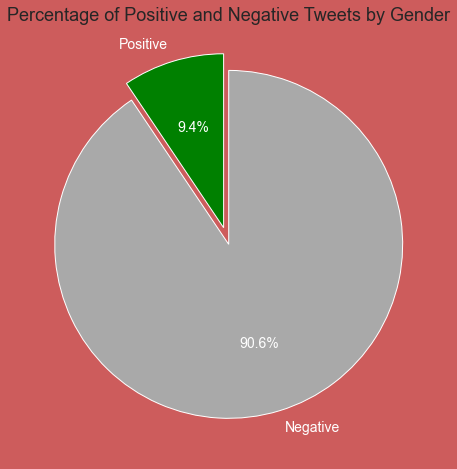

In [122]:
# Filter the data to only include data for male
male_df = df[df["gender"] == "male"]
# Group the tweets by label, and count the number of tweets in each group
label_counts = male_df.groupby("label").size()
# Calculate the percentage of positive and negative tweets
total_tweets = label_counts.sum()
positive_percentage = label_counts[1] / total_tweets * 100
negative_percentage = label_counts[0] / total_tweets * 100
# Create a pie chart of the percentage of positive and negative tweets
labels = ["Positive", "Negative"]
sizes = [label_counts[1], label_counts[0]]
colors = ["green", "darkgray"]
explode = (0.1, 0)  # explode the positive slice
fig, ax = plt.subplots(figsize=(15, 8), facecolor="#CD5C5C")
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90, textprops={"color": "w", "fontsize": 14})
ax.set_title("Percentage of Positive and Negative Tweets by Gender", fontsize=18)
# Show the plot
plt.show()


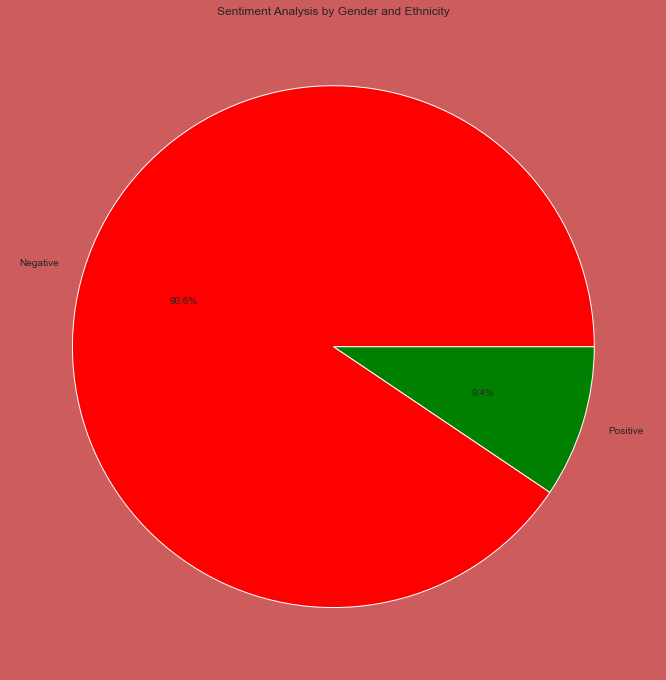

In [123]:
df["text"] = df["text"].astype(str)
# Group the tweets by gender, ethnic and label, and count the number of tweets in each group
gender_ethnic_label_counts = df.groupby(["gender", "ethnic", "label"]).size().unstack(level=2)
# Calculate the percentage of positive and negative tweets for each gender and ethnic group
gender_ethnic_label_counts["Total"] = gender_ethnic_label_counts.sum(axis=1)
gender_ethnic_label_counts["Positive %"] = gender_ethnic_label_counts[1] / gender_ethnic_label_counts["Total"] * 100
gender_ethnic_label_counts["Negative %"] = gender_ethnic_label_counts[0] / gender_ethnic_label_counts["Total"] * 100

# Create a single pie chart for all gender and ethnicity combinations, with the percentage of positive and negative tweets
fig, ax = plt.subplots(figsize=(15, 12), facecolor="#CD5C5C")
colors = ["green", "red"]
labels = ["Positive", "Negative"]
sizes = []
for group in gender_ethnic_label_counts.index:
    sizes.extend(gender_ethnic_label_counts.loc[group, [1, 0]].fillna(0))
ax.pie(sizes, labels=labels*len(gender_ethnic_label_counts.index), colors=colors*len(gender_ethnic_label_counts.index), autopct="%1.1f%%",counterclock=False)
ax.set_title("Sentiment Analysis by Gender and Ethnicity", fontsize=12)
# Show the plot
plt.show()

##### Sentiment analysis

In [124]:

def get_sentiment(label):
    if label == 1:
        return "positive"
    else:
        return "negative"
df["sentiment"] = df["label"].apply(get_sentiment)

# def get_sentiment(text, label):
#     """
#     Takes in the text of a tweet and its label, and returns the sentiment of the tweet.
#     If the label is 1, the sentiment is positive; otherwise, the sentiment is negative.
#     """
#     if label == 1:
#         sentiment = TextBlob(text).sentiment.polarity
#         if sentiment > 0:
#             return "positive"
#         elif sentiment == 0:
#             return "neutral"
#         else:
#             return "negative"
#     else:
#         sentiment = TextBlob(text).sentiment.polarity
#         if sentiment > 0:
#             return "negative"
#         elif sentiment == 0:
#             return "neutral"
#         else:
#             return "positive"
# df["sentiment"] = df.apply(lambda x: get_sentiment(x["text"], x["label"]), axis=1)


In [125]:
df[["label","sentiment"]].sample(5)

,label,sentiment
42,0,negative
0,0,negative
29,0,negative
21,0,negative
14,0,negative


##### Common positive words

In [126]:
positive_tweets = df[df["label"] == 1]
# textblob 
sentiments = positive_tweets["text"].apply(lambda x: TextBlob(x).sentiment)

# extract the polarity scores 
polarity_scores = sentiments.apply(lambda x: x.polarity)

#calculate the frequency of each polarity score
polarity_counts =  polarity_scores.value_counts()
print(polarity_counts.head())


0.000    3
0.295    1
0.250    1
Name: text, dtype: int64


##### Common negative words

In [127]:
stop_words = set(stopwords.words("english"))
# process positive tweets, tokenize and remove stopwords
positive_tweets = df[df["label"] == 1].copy()
positive_tweets["tokens"] = positive_tweets["text"].apply(lambda x: nltk.word_tokenize(x.lower()))
positive_tweets["tokens"] = positive_tweets["tokens"].apply(lambda x: [token for token in x if token.isalpha() and token not in stop_words])
# get top 10 most common words
top_words = (positive_tweets["tokens"]
             .apply(pd.Series, dtype=object)
             .stack()
             .value_counts()
             .head(10)
             .rename_axis("word")
             .reset_index(name="count"))
print(top_words)


         word  count
0  university      3
1       asked      2
2     taliban      2
3          rt      2
4     haqqani      2
5    requires      1
6      higher      1
7    salaries      1
8    awakener      1
9        east      1


In [128]:
positive_tweets = df[df["label"] == 1]
# calculate sentiment polarity scores using TextBlob
sentiments = positive_tweets["text"].apply(lambda x: TextBlob(x).sentiment)
# extract the polarity scores 
polarity_scores = sentiments.apply(lambda x: x.polarity)
# count the frequency of each polarity score
polarity_counts = polarity_scores.value_counts()
# calculate the percentage of each polarity score
polarity_percentages = (polarity_counts / len(positive_tweets)) * 100
# print the top 5 most common polarity scores with their percentage
print("Top 5 Most Common Polarity Scores:")
for i, (score, count) in enumerate(polarity_counts.head(5).items()):
    percentage = polarity_percentages.loc[score]
    print(f"{i+1}. {score:.2f}: {count} ({percentage:.2f}%)")


Top 5 Most Common Polarity Scores:
1. 0.00: 3 (60.00%)
2. 0.30: 1 (20.00%)
3. 0.25: 1 (20.00%)


Top 5 Most Common Polarity Scores:
1. 0.00: 3 (60.00%)
2. 0.30: 1 (20.00%)
3. 0.25: 1 (20.00%)


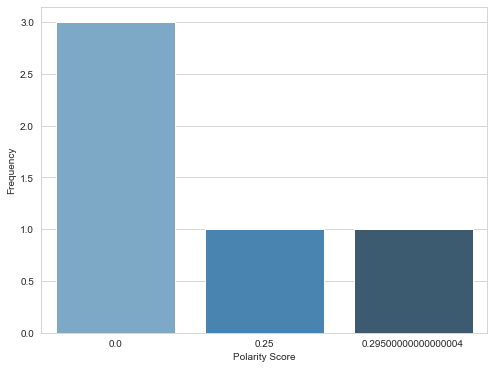

In [129]:

# calculate sentiment polarity scores using TextBlob
sentiments = df[df["label"] == 1]["text"].apply(lambda x: TextBlob(x).sentiment)

# extract the polarity scores 
polarity_scores = sentiments.apply(lambda x: x.polarity)

# count the frequency of each polarity score
polarity_counts = polarity_scores.value_counts().head()

# calculate the percentage of each polarity score
polarity_percentages = (polarity_counts / len(df[df["label"] == 1])) * 100

# print the top 5 most common polarity scores with their percentage
print("Top 5 Most Common Polarity Scores:")
for i, (score, count) in enumerate(polarity_counts.items()):
    percentage = polarity_percentages.loc[score]
    print(f"{i+1}. {score:.2f}: {count} ({percentage:.2f}%)")

# create a bar chart of the polarity scores
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
ax = sns.barplot(x=polarity_counts.index, y=polarity_counts.values, palette="Blues_d")
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Frequency")
plt.show()


##### Mean of the tweets

In [130]:
positive_tweets = df[df["label"] == 1]
sentiments = positive_tweets["text"].apply(lambda x: TextBlob(x).sentiment)
polarity_scores = sentiments.apply(lambda x: x.polarity)
# calculate the mean polarity score
mean_polarity = polarity_scores.mean()
print((mean_polarity))


0.10900000000000001


##### Transforming Tweets into Numerical

Fitting and transforming the entire text data df["text"] using TfidfVectorizer, and then storing the transformed data in X_tfidf.



In [131]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create the TF-IDF feature vectors for the tweets
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df["text"])

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_tfidf, df["label"])

# Make predictions on the same dataset
y_pred = model.predict(X_tfidf)

# Calculate the metrics
accuracy = accuracy_score(df["label"], y_pred)
precision = precision_score(df["label"], y_pred, zero_division=0.0)
recall = recall_score(df["label"], y_pred)
f1 = f1_score(df["label"], y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Accuracy: 0.9056603773584906
Precision: 0.0
Recall: 0.0
F1 score: 0.0


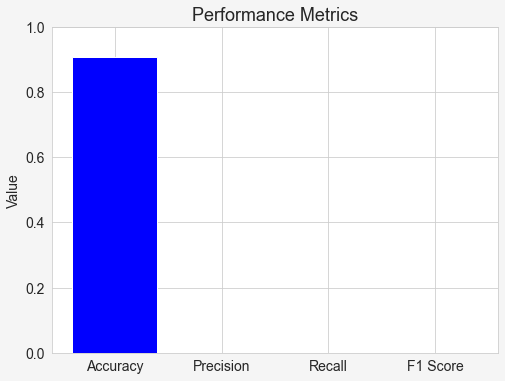

In [132]:
# Create a bar chart of the metrics
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = np.array([accuracy, precision, recall, f1])
colors = ["blue", "red", "green", "purple"]
fig, ax = plt.subplots(figsize=(8, 6), facecolor="#F5F5F5")
ax.bar(labels, values, color=colors)
ax.set_title("Performance Metrics", fontsize=18)
ax.set_ylim(0, 1)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=14)
plt.show()


##### Feature engineering

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Feature engineering: add a new column for the length of each tweet
df['length'] = df['text'].apply(len)

# Create the TF-IDF feature vectors for the tweets
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['text'])

# Add the length as a new feature to the feature matrix
X_with_length = np.concatenate((X_tfidf.toarray(), np.array(df['length']).reshape(-1,1)), axis=1)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_with_length, df['label'])

# Make predictions on the same dataset
y_pred = model.predict(X_with_length)

# Calculate the metrics
accuracy = accuracy_score(df['label'], y_pred)
precision = precision_score(df['label'], y_pred, zero_division=0.0)
recall = recall_score(df['label'], y_pred)
f1 = f1_score(df['label'], y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Accuracy: 0.9056603773584906
Precision: 0.0
Recall: 0.0
F1 score: 0.0
